In [228]:
import pandas as pd
import numpy as np
import networkx as nx

import pickle
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 11)}, font_scale=2)

from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks, peak_widths


# Import Custom packages
import sys
sys.path.append('../../')
import utils
import semantic_type_propagation as stp

# Functions

In [229]:
def get_vals_in_range(m, lower_bound=0, upper_bound=0.99):
    '''
    Given a numpy array `m`, return a list with all values in `m` that are within range specified by `lower_bound` and `upper_bound` 
    '''
    m_list = m.flatten().tolist()
    m_list = [val for val in m_list if  lower_bound < val < upper_bound]
    return m_list 


def get_epsilon(m, lower_bound=0, upper_bound=0.99, mode='greatest', num_samples=1000, rel_height=1, bandwidth_multiplier=20):
    '''
    m is a distance matrix

    Whenever 'm_list' is empty return an epsilon of 1-`upper_bound`

    mode must be one of 'kde' or 'greatest' 
    '''
    m_list = get_vals_in_range(m, lower_bound=lower_bound, upper_bound=upper_bound)

    # Check if m_list is empty
    if len(m_list) == 0:
        return 1-upper_bound
    
    if mode == 'greatest':
        return max(m_list)
    elif mode == 'kde':
        density, samples, lower_bnd, upper_bnd = get_kde(m_list, bandwidth_multiplier=bandwidth_multiplier, num_samples=num_samples)
        widths, width_heights, left_pos, right_pos = get_peak_widths(
            density=density,
            lower_bnd=lower_bnd,
            upper_bnd=upper_bnd,
            num_samples=num_samples,
            rel_height=rel_height
        )

        if len(widths) > 1:
            # Do not consider the last peak as it corresponds to distances across different types
            epsilon = max(right_pos[:-1])
        else:
            # There is only one peak. Choose the left_pos instead
            epsilon = max(left_pos)

        if epsilon >= 1:
            # Ensure that epsilon is less than 1
            positive_right_pos = [val for val in right_pos if val < 1]
            epsilon = max(positive_right_pos)

        return epsilon
        

def get_kde(vals, bandwidth_multiplier=20, num_samples=1000, boundary_proportion=0.1):
    '''
    Given a list of uniformly seperated values `vals` estimate density distribution using KDE

    The range of the samples is specified

    Returns two lists, the density and the samples at which the density is estimated at
    '''

    # Compute the range of `vals` and assign upper and lower boundaries for the samples 
    vals_range = max(vals) - min(vals)

    if vals_range == 0:
        # If all values in `vals` have the same value then set the lower bound to 0 and the upper bound to 1
        samples_lower_bnd = 0
        samples_upper_bnd = 1
    else:
        samples_lower_bnd = min(vals) - boundary_proportion*vals_range
        samples_upper_bnd = max(vals) + boundary_proportion*vals_range

    # Compute the KDE curve
    points = np.array(np.array(vals)).reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=((samples_upper_bnd - samples_lower_bnd)/num_samples)*bandwidth_multiplier).fit(points)
    samples = np.linspace(samples_lower_bnd, samples_upper_bnd, num=num_samples)
    density = np.exp(kde.score_samples(samples.reshape(-1,1)))

    return density, samples, samples_lower_bnd, samples_upper_bnd

def get_peak_widths(density, lower_bnd, upper_bnd, num_samples, rel_height=0.5):
    '''
    Returns 4 lists all in the original space:

    widths: the widths for each peak 
    width_heights: the heights where the widths are evaluated
    left_pos: the positions of the left intersepction points of the horizontal line with the evaluation height
    right_pos: the positions of the right intersepction points of the horizontal line with the evaluation height
    '''
    # Find the peaks
    peaks, _ = find_peaks(density)

    # Find the widths of each peak with their respective locations and height
    widths, width_heights, left_ips, right_ips = peak_widths(density, peaks, rel_height=rel_height)

    range_length = upper_bnd - lower_bnd
    length_per_sample = range_length / num_samples

    # Convert the left_ips and right_ips from the sample space to the original space (0-1)
    widths = widths * length_per_sample
    left_pos = (left_ips * length_per_sample) + lower_bnd
    right_pos = (right_ips * length_per_sample) + lower_bnd

    return widths, width_heights, left_pos, right_pos

# Jaccard Similarity

In [230]:
df_path = '../../output/synthetic_example_large/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large/input_nodes.json'
matrices_path = df_path + 'num_meanings/jaccard/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_with_groundtruth_df.pickle')
G = pickle.load(open(g_path, "rb"))

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df_homs = df[df['is_homograph']==True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

100%|██████████| 180/180 [00:00<00:00, 4051.23it/s]

There are 6502 cell nodes with a degree greater than 1
There are 611 unique ranks based on BC.


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
7590,Palm,cell,1.445700e-02,True,1.0,2
25825,Clementine,cell,8.975958e-03,True,2.0,2
7130,Magnolia,cell,8.132084e-03,True,3.0,2
3077,Jaguar,cell,8.049376e-03,True,4.0,2
7416,Timothy,cell,6.921700e-03,True,5.0,2
...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2
1828,SD,cell,2.059766e-07,True,276.0,2
2004,ME,cell,1.214843e-07,True,314.0,2
1950,NC,cell,7.969017e-08,True,329.0,2


In [231]:
df_homs['num_meanings_groundtruth'].value_counts()

2    176
3      4
Name: num_meanings_groundtruth, dtype: int64

In [232]:
df_homs[df_homs['num_meanings_groundtruth'] > 2]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
300,Lincoln,cell,0.004879,True,8.0,3
2012,Montana,cell,0.002381,True,15.0,3
1401,Aurora,cell,0.001690,True,20.0,3
546,Virginia,cell,0.001467,True,25.0,3


In [233]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [234]:
test_homograph = 'MA'
# m = np.load(matrices_path + test_homograph +'.npy')
# idx_to_node = pickle.load(open(matrices_path + test_homograph + '_idx_to_node.pickle', 'rb'))
print('Homograph:', test_homograph)
print('Distance Matrix:\n', node_to_matrix_dict[test_homograph])

print('Index to node dictionary:', node_to_idx_dict[test_homograph])
print('Column names that homograph is connected to:', utils.graph_helpers.get_cell_node_column_names(G, test_homograph))

labels = DBSCAN(min_samples=1, metric='precomputed', eps=0.5).fit_predict(node_to_matrix_dict[test_homograph])
print(labels)

Homograph: MA
Distance Matrix:
 [[0.         0.32885906 0.33561644 0.42307692 0.39354839 0.33333333
  0.3537415  0.36666667 0.91390728 0.93243243]
 [0.32885906 0.         0.32214765 0.36774194 0.4        0.38461538
  0.35099338 0.32       0.91082803 0.91447368]
 [0.33561644 0.32214765 0.         0.30821918 0.36601307 0.38157895
  0.34693878 0.37086093 0.90728477 0.92567568]
 [0.42307692 0.36774194 0.30821918 0.         0.35714286 0.38311688
  0.38157895 0.32885906 0.90196078 0.91275168]
 [0.39354839 0.4        0.36601307 0.35714286 0.         0.36363636
  0.35099338 0.35294118 0.90384615 0.92156863]
 [0.33333333 0.38461538 0.38157895 0.38311688 0.36363636 0.
  0.32191781 0.4        0.90849673 0.92666667]
 [0.3537415  0.35099338 0.34693878 0.38157895 0.35099338 0.32191781
  0.         0.37748344 0.89932886 0.91780822]
 [0.36666667 0.32       0.37086093 0.32885906 0.35294118 0.4
  0.37748344 0.         0.89403974 0.91946309]
 [0.91390728 0.91082803 0.90728477 0.90196078 0.90384615 0.9084

In [235]:
df['num_meanings'] = np.nan
df['epsilon'] = np.nan
homs_with_noise=0
num_non_trivial_predictions = 0

mode = 'kde'

# Loop over the input nodes and estimate the number of meanings 
for node in input_nodes:
    # Check number of attributes 'node' is connected to
    if len(utils.graph_helpers.get_attribute_of_instance(G, node)) > 2:
        m = node_to_matrix_dict[node]
        idx_to_node = node_to_idx_dict[node]

        epsilon = get_epsilon(m, lower_bound=0, upper_bound=1, mode='kde', num_samples=1000, rel_height=0.999, bandwidth_multiplier=20)

        labels = DBSCAN(min_samples=1, metric='precomputed', eps=epsilon).fit_predict(m)

        if -1 in labels:
            homs_with_noise += 1

        num_meanings = len(set(labels))
        df.loc[df['node'] == node, 'num_meanings'] = num_meanings
        df.loc[df['node'] == node, 'epsilon'] = epsilon
        num_non_trivial_predictions+=1
    else:
        df.loc[df['node'] == node, 'num_meanings'] = 2

print("Number of homographs with noise:", homs_with_noise)
print("Number of non-trivial predictions:", num_non_trivial_predictions)
df['is_num_meanings_correct'] = df['num_meanings'] == df['num_meanings_groundtruth']
df[df['is_homograph']==True]

Number of homographs with noise: 0
Number of non-trivial predictions: 102


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings,epsilon,is_num_meanings_correct
7590,Palm,cell,1.445700e-02,True,1.0,2,2.0,0.973208,True
25825,Clementine,cell,8.975958e-03,True,2.0,2,2.0,0.828506,True
7130,Magnolia,cell,8.132084e-03,True,3.0,2,2.0,NaN,True
3077,Jaguar,cell,8.049376e-03,True,4.0,2,2.0,0.763031,True
7416,Timothy,cell,6.921700e-03,True,5.0,2,2.0,NaN,True
...,...,...,...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2,2.0,0.446164,True
1828,SD,cell,2.059766e-07,True,276.0,2,2.0,0.446536,True
2004,ME,cell,1.214843e-07,True,314.0,2,2.0,0.424851,True
1950,NC,cell,7.969017e-08,True,329.0,2,2.0,0.351996,True


In [236]:
df_homs = df[df['is_homograph']==True]
df_homs['is_num_meanings_correct'].value_counts()

True     174
False      6
Name: is_num_meanings_correct, dtype: int64

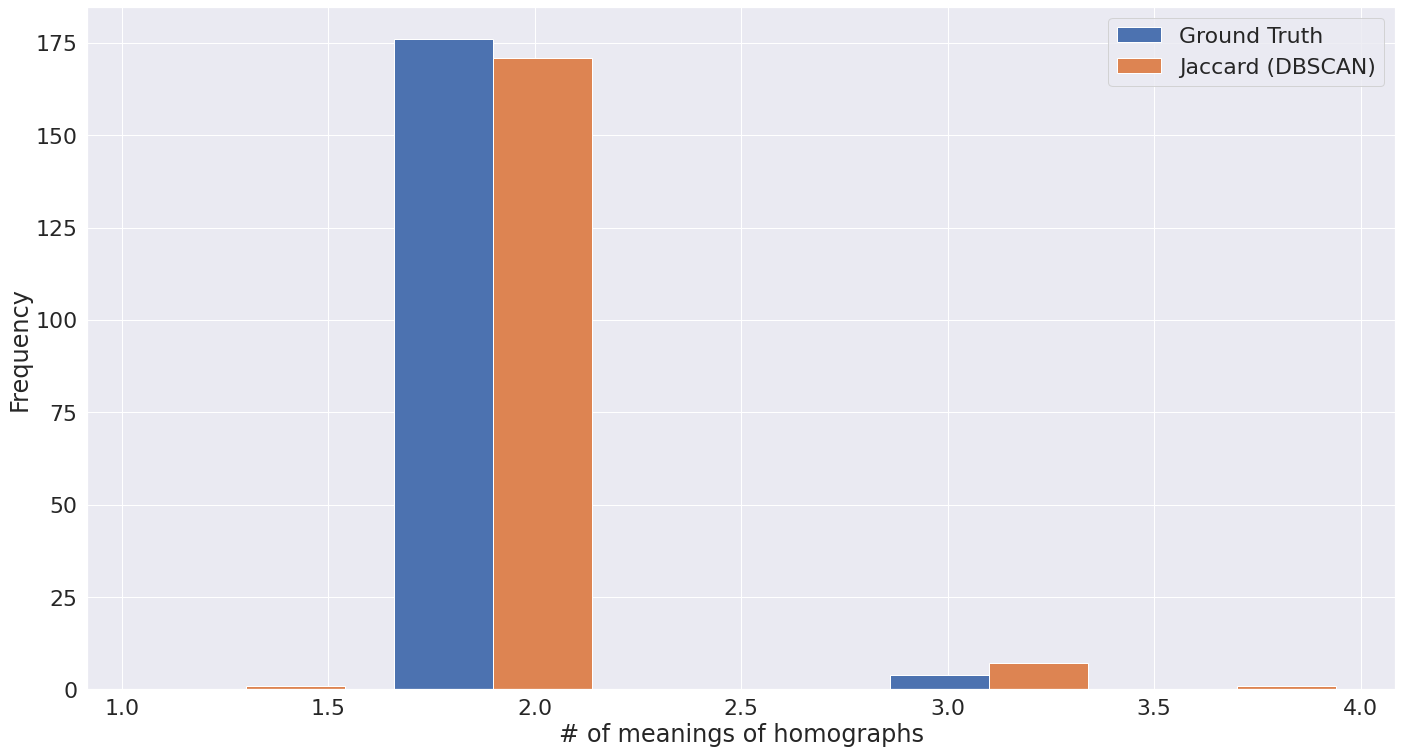

In [237]:
ax = plt.hist([df_homs['num_meanings_groundtruth'], df_homs['num_meanings']], bins=5, label=['Ground Truth', 'Jaccard (DBSCAN)'])
plt.xlabel('# of meanings of homographs');plt.ylabel('Frequency');plt.legend();plt.tight_layout()
# plt.savefig('../../figures/num_meanings/TUS/num_meanings_top_300_propagation_histogram.svg')

In [238]:
df_homs[df_homs['is_num_meanings_correct']==False]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings,epsilon,is_num_meanings_correct
300,Lincoln,cell,0.004879,True,8.0,3,4.0,0.623339,False
24153,Darcy,cell,0.001545,True,23.0,2,1.0,0.997867,False
1174,Chicago,cell,0.001432,True,27.0,2,3.0,0.589618,False
590,Brooklyn,cell,0.001227,True,31.0,2,3.0,0.589633,False
723,Jamaica,cell,0.001169,True,33.0,2,3.0,0.841035,False
18618,Kansas,cell,0.000264,True,80.0,2,3.0,0.199021,False


# Testing

In [252]:
node = 'Jamaica'
print(node_to_idx_dict[node])
node_to_matrix_dict[node]

{0: 'city_location_city_country_1.csv', 1: 'city_location_city_country_2.csv', 2: 'country_location_city_country_1.csv', 3: 'country_location_country_country_code_1.csv', 4: 'country_location_country_country_code_2.csv', 5: 'country_nature_animal_name_scientific_name_country_1.csv', 6: 'country_nature_animal_name_scientific_name_country_2.csv', 7: 'country_nature_plant_name_scientific_name_family_country_1.csv', 8: 'country_nature_plant_name_scientific_name_family_country_2.csv', 9: 'country_nature_plant_name_scientific_name_family_country_3.csv', 10: 'country_personal_company_name_full_name_country_1.csv', 11: 'country_personal_company_name_full_name_country_2.csv', 12: 'country_personal_company_name_full_name_country_3.csv', 13: 'country_product_grocery_country_1.csv', 14: 'country_product_grocery_country_2.csv'}


array([[0.        , 0.98106592, 0.99908925, 0.99908509, 0.99909091,
        0.99908004, 0.99909502, 0.99908925, 0.99908509, 0.99908088,
        0.99908676, 0.99909256, 0.9990942 , 0.99909008, 0.99908257],
       [0.98106592, 0.        , 0.99834711, 0.99833333, 0.99835255,
        0.9983165 , 0.99836601, 0.99834711, 0.99833333, 0.99831933,
        0.99833887, 0.99835796, 0.99836334, 0.99834983, 0.99832496],
       [0.99908925, 0.99834711, 0.        , 0.35333333, 0.37179487,
        0.38255034, 0.36075949, 0.39490446, 0.42675159, 0.37583893,
        0.30612245, 0.38993711, 0.40740741, 0.37820513, 0.39473684],
       [0.99908509, 0.99833333, 0.35333333, 0.        , 0.32885906,
        0.36111111, 0.37179487, 0.40645161, 0.30769231, 0.40939597,
        0.38410596, 0.37012987, 0.33552632, 0.34666667, 0.37414966],
       [0.99909091, 0.99835255, 0.37179487, 0.32885906, 0.        ,
        0.38      , 0.33757962, 0.38216561, 0.32885906, 0.39473684,
        0.40127389, 0.36708861, 0.36477987, 

Vals: [0.9810659186535764, 0.9990892531876139, 0.9990850869167429, 0.9990909090909091, 0.9990800367985281, 0.9990950226244344, 0.9990892531876139, 0.9990850869167429, 0.9990808823529411, 0.9990867579908675, 0.9990925589836661, 0.9990942028985508, 0.9990900818926297, 0.9990825688073395, 0.9810659186535764, 0.9983471074380166, 0.9983333333333333, 0.9983525535420099, 0.9983164983164983, 0.9983660130718954, 0.9983471074380166, 0.9983333333333333, 0.9983193277310924, 0.9983388704318937, 0.9983579638752053, 0.9983633387888707, 0.9983498349834984, 0.998324958123953, 0.9990892531876139, 0.9983471074380166, 0.3533333333333334, 0.3717948717948718, 0.3825503355704698, 0.3607594936708861, 0.39490445859872614, 0.4267515923566879, 0.37583892617449666, 0.30612244897959184, 0.389937106918239, 0.40740740740740744, 0.3782051282051282, 0.39473684210526316, 0.9990850869167429, 0.9983333333333333, 0.3533333333333334, 0.32885906040268453, 0.36111111111111116, 0.3717948717948718, 0.40645161290322585, 0.30769

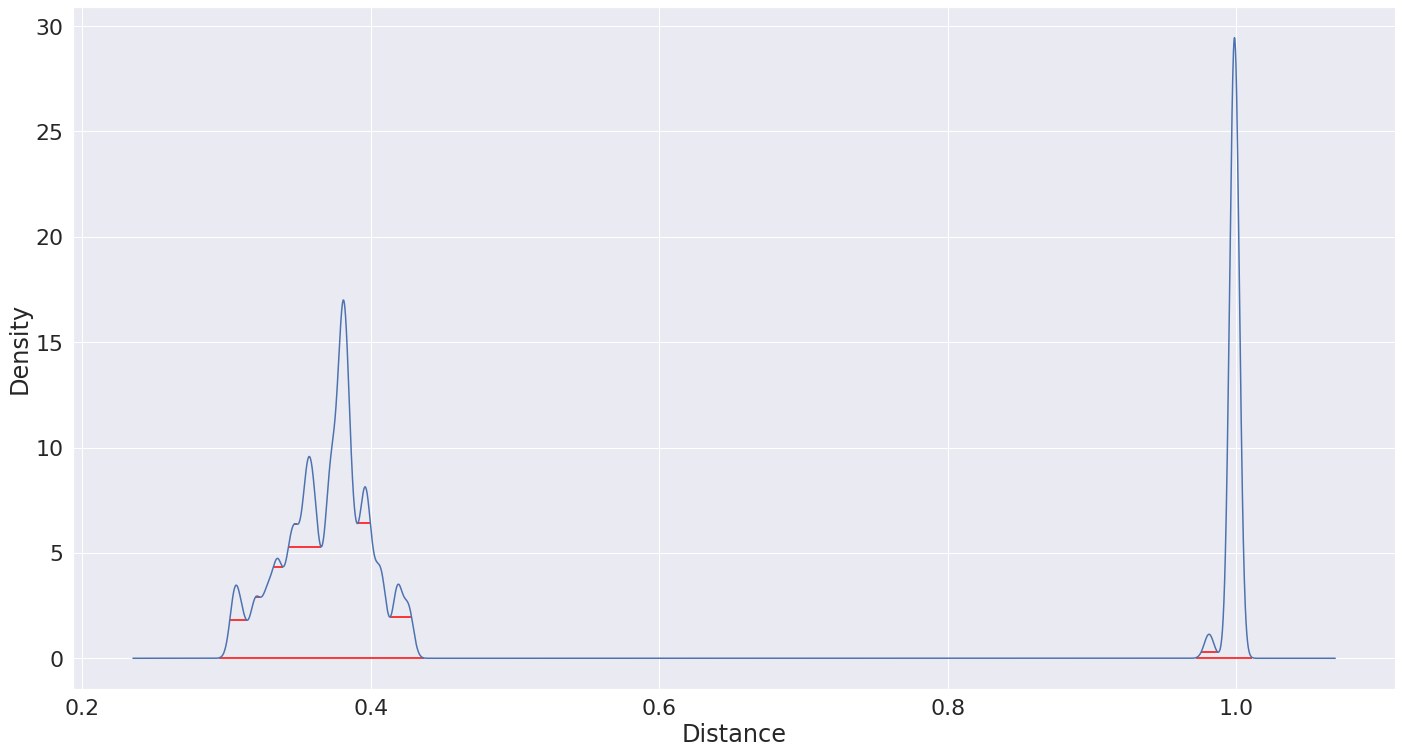

In [255]:
num_samples=5000
vals = get_vals_in_range(node_to_matrix_dict[node], lower_bound=0, upper_bound=1)
density, samples, lower_bnd, upper_bnd = get_kde(vals, bandwidth_multiplier=20, num_samples=num_samples)

widths, width_heights, left_pos, right_pos = get_peak_widths(density, lower_bnd, upper_bnd, num_samples=num_samples, rel_height=0.999)

epsilon = max(right_pos)
print('Vals:', vals)
print(widths, width_heights, left_pos, right_pos)
print('Epsilon:', epsilon)

plt.plot(samples, density)
plt.hlines(y=width_heights, xmin=left_pos, xmax=right_pos, colors='red')
plt.xlabel('Distance');plt.ylabel('Density');plt.tight_layout()

In [251]:
epsilon = get_epsilon(node_to_matrix_dict[node], lower_bound=0, upper_bound=1, mode='kde', num_samples=1000, rel_height=0.999, bandwidth_multiplier=20)
epsilon

0.8410352614617482

In [256]:
labels = DBSCAN(min_samples=1, metric='precomputed', eps=0.99).fit_predict(node_to_matrix_dict[node])
print(node_to_idx_dict[node])
print(labels)

{0: 'city_location_city_country_1.csv', 1: 'city_location_city_country_2.csv', 2: 'country_location_city_country_1.csv', 3: 'country_location_country_country_code_1.csv', 4: 'country_location_country_country_code_2.csv', 5: 'country_nature_animal_name_scientific_name_country_1.csv', 6: 'country_nature_animal_name_scientific_name_country_2.csv', 7: 'country_nature_plant_name_scientific_name_family_country_1.csv', 8: 'country_nature_plant_name_scientific_name_family_country_2.csv', 9: 'country_nature_plant_name_scientific_name_family_country_3.csv', 10: 'country_personal_company_name_full_name_country_1.csv', 11: 'country_personal_company_name_full_name_country_2.csv', 12: 'country_personal_company_name_full_name_country_3.csv', 13: 'country_product_grocery_country_1.csv', 14: 'country_product_grocery_country_2.csv'}
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
